In [194]:
from collections import namedtuple
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from skimage.filters import difference_of_gaussians
from skimage import img_as_float

In [195]:
def show_images(images, titles=None):
    num_images = len(images)
    
    if titles is None:
        titles = ['Image {}'.format(i + 1) for i in range(num_images)]

    figsize = (5 * num_images, 5)
    plt.subplots(1, num_images, figsize=figsize)
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        if len(images[i].shape) == 3:  # Color image
            img_display = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
            plt.imshow(img_display)
        else:  # Grayscale image
            plt.imshow(images[i], cmap="gray")  
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [202]:
Circle = namedtuple("Circle", ["x", "y", "r"])
Rectangle = namedtuple("Rectangle", ["x_l", "y_b", "x_r", "y_t"])


def apply_dog(image: np.array, sigma: int, threshold=0.03) -> Tuple[np.array, np.array]:
   """
   Apply difference of gaussians
   """
   float_image = img_as_float(image)
   dog_image = difference_of_gaussians(float_image, sigma, 1.6 * sigma)

   mask = dog_image.copy()
   _, mask = cv2.threshold(mask, threshold, 1, cv2.THRESH_BINARY)
   mask = mask.astype(np.uint8)

   return mask, dog_image


def get_figures_from_contours(contours, image_shape, threshold) -> Tuple[List[Rectangle], List[Circle]]:
   """
      Extract bounding boxes as rectangles and circles from the contours
   """
   rectangles = []
   circles = []

   for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)

      # Get the circle around the ROI
      center = (x + w // 2, y + h // 2)
      radius = int(max(w, h) / 2)
      circle = Circle(x=center[0], y=center[1], r=radius)
      
      # filter by size
      if circle.r < threshold * image_shape[0]:
         circles.append(circle)     
         rectangles.append(Rectangle(x_l=x, y_b=y, x_r=x+w, y_t=y+h))

   return rectangles, circles     


def detect_blobs(image: np.array, sigma: int, threshold: float) -> Tuple[Tuple[np.array], np.array, np.array]:
   """ Get contours of blobs from the image """
   mask, dog_image = apply_dog(image,  sigma, threshold)
   contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

   return contours, dog_image, mask

def draw_litter(image, sigma, dog_threshold, size_max_threshold, circles=True, rectangles=False, contours=False):
   blob_contours, dog_image, mask = detect_blobs(image, sigma, dog_threshold)
   bb_rectangles, bb_circles = get_figures_from_contours(blob_contours, image.shape, size_max_threshold)

   # Draw the contours
   im_detected = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
   if contours:
      cv2.drawContours(im_detected, blob_contours, -1, (100,200,0), 2)
   if circles:
      for circle in bb_circles:
         cv2.circle(im_detected, (circle.x, circle.y), circle.r, (255,0,0), 2)
   if rectangles:
      for rectangle in bb_rectangles:
         cv2.rectangle(im_detected, (rectangle.x_l, rectangle.y_b), (rectangle.x_r, rectangle.y_t), (255,0,0), 2)

   return im_detected, dog_image, mask


In [203]:
def find_pool(image: np.array) -> Rectangle:

    image = cv2.GaussianBlur(image, (23,23), 0)

    image[image<130] = 0
    image[image>=130] = 255

    # Apply Sobel filter (gradient in x and y directions)
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    edges = cv2.magnitude(sobel_x, sobel_y)
    edges = cv2.convertScaleAbs(edges)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest quadrilateral with the correct ratio (pool) in the image

    max_area_rectangle = None
    max_area = 0
    for contour in contours:
        # Approximate the contour to reduce the number of points
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the approximated contour has 4 vertices (indicating a quadrilateral)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h

            # Define acceptable aspect ratio range for rectangles
            if 1.5 < aspect_ratio < 2.5:  # Adjust this range as needed

                # get the largest rectangle
                area = cv2.contourArea(approx)
                if area > max_area:
                    max_area = area
                    max_area_rectangle = Rectangle(x_l=x, y_b=y, x_r=x+w, y_t=y+h)        

    return max_area_rectangle

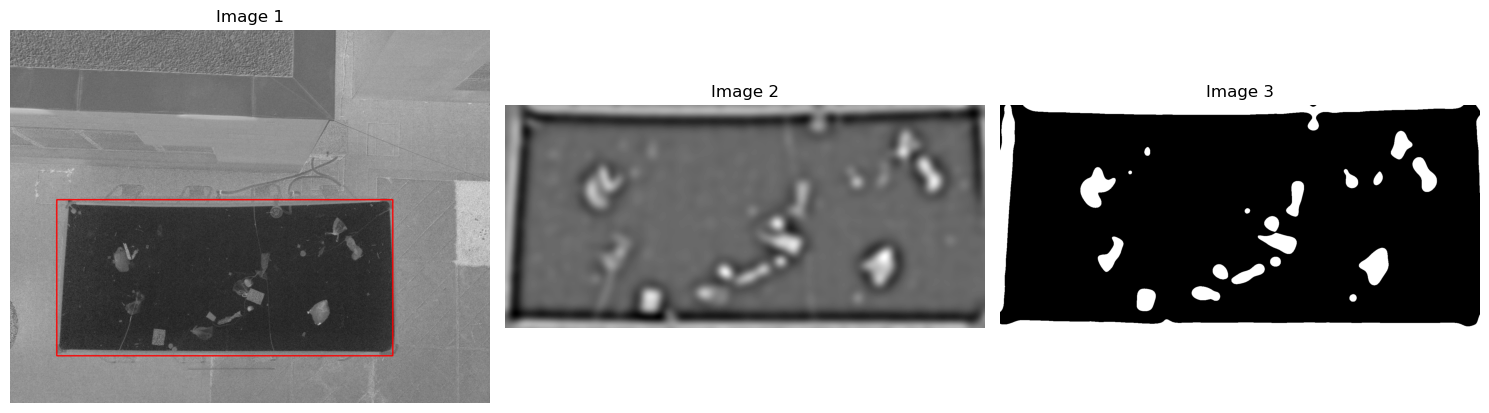

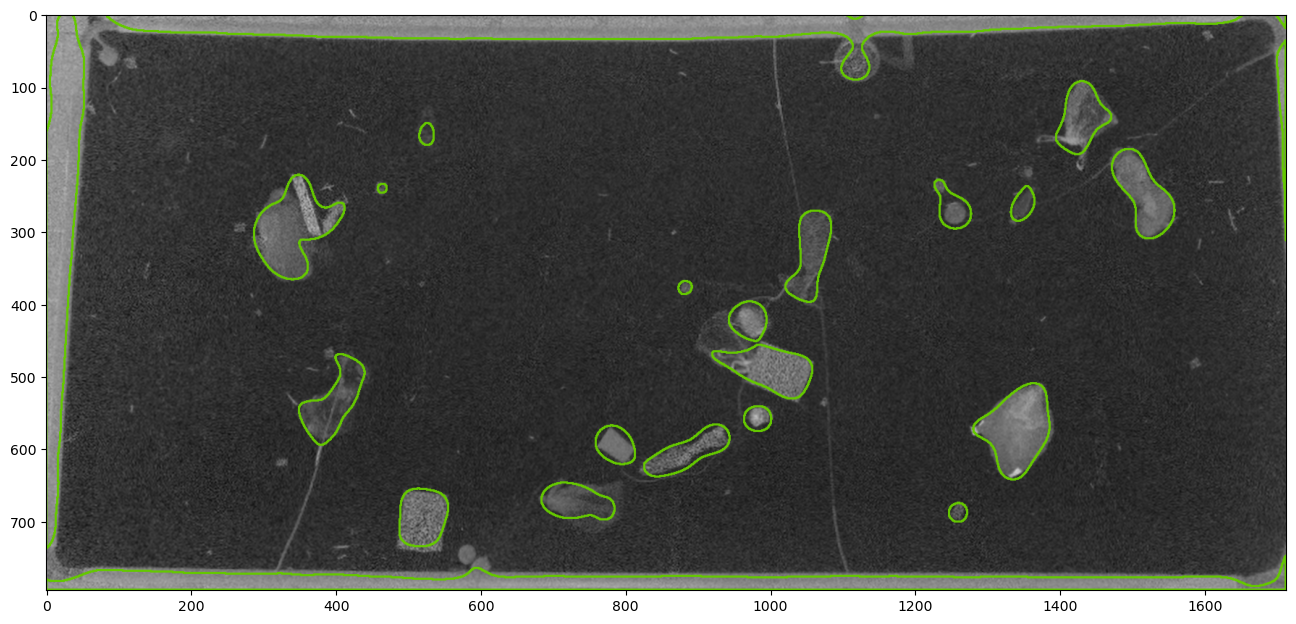

In [209]:
dog_threshold = 0.01
size_max_threshold = 1/10 # as percentage of the photo width
im_path = "./0021_10_meanRE.png"
sigma = 16

image = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)
pool = find_pool(image)

cropped_image = image[pool.y_b:pool.y_t, pool.x_l:pool.x_r]
im_litter, dog_image, mask = draw_litter(cropped_image, sigma, dog_threshold, size_max_threshold, circles=False, rectangles=False, contours=True)


# show pool on the drone image
im_pool = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
cv2.rectangle(im_pool, (pool.x_l, pool.y_b), (pool.x_r, pool.y_t), (0,0,255), 5)

show_images([im_pool, dog_image, mask])

plt.figure(figsize=(16,8))
plt.imshow(im_litter)
plt.show()